# ResNet

In [1]:
import tensorflow as tf

In [2]:
num_classes = 10
input_shape = [224, 224, 3]

batch_size = 16
num_epochs = 10

## Create model

In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, \
                                MaxPooling2D, AveragePooling2D, BatchNormalization, add

import functools

In [1]:
from IPython.display import Image

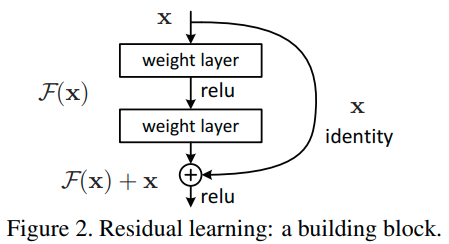

In [4]:
Image('image/resnet_fig_2.png')

In [4]:
def res_conv(filters, kernel_size=3, padding='same', 
             strides=1, activation=True):
    def layer_fn(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                     padding=padding, strides=strides)(x)
        x = BatchNormalization(axis=-1)(x)
        if activation:
            x = Activation('relu')(x)
        return x
    return layer_fn

In [5]:
def merge_with_shortcut():
    def layer_fn(x, x_residual):
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2])) # horizontal stride    
            )
            x_residual_channels = x_residual_shape[3]
            
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=1, 
                padding='valid', strides=strides)(x)
        
        return add([shortcut, x_residual])
    return layer_fn

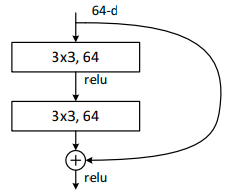

In [5]:
Image('image/resnet_basic_block.png')

In [6]:
def basic_block(filters, kernel_size=3, strides=1,
                name='basic_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters, kernel_size=kernel_size,
                    padding='same', strides=strides)(x)
        x_residual = res_conv(filters=filters, kernel_size=kernel_size,
                    padding='same', strides=1, activation=False)(x_residual)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        
        return x
    return layer_fn

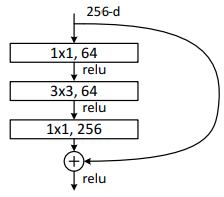

In [6]:
Image('image/resnet_bottleneck_block.png')

In [7]:
def bottleneck_block(filters, kernel_size=3, strides=1, 
                     name='bottleneck_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=strides)(x)
        x_residual = res_conv(filters=filters, kernel_size=kernel_size,
                    padding='same', strides=1)(x_residual)
        x_residual = res_conv(filters=filters * 4, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [8]:
def ResNet(input_shape, num_classes, block_fn, repetitions, start_filters=64):
    filters = start_filters
    
    input = Input(shape=input_shape)
    x = res_conv(filters=filters, kernel_size=7, strides=2, padding='same')(input)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    for i, repeat in enumerate(repetitions):
        strides_1st = 1 if i == 0 else 2
        for j in range(repeat):
            strides = strides_1st if j == 0 else 1
            x = block_fn(filters=filters, kernel_size=3, strides=strides)(x)
        filters = min(filters * 2, 1024)
    
    block_output_shape = tf.keras.backend.int_shape(x)[1:3]
    x = AveragePooling2D(pool_size=block_output_shape, strides=1)(x)
    x = Flatten()(x)
    output = Dense(units=num_classes, activation='softmax')(x)
    
    model = Model(inputs=input, outputs=output)
    
    return model

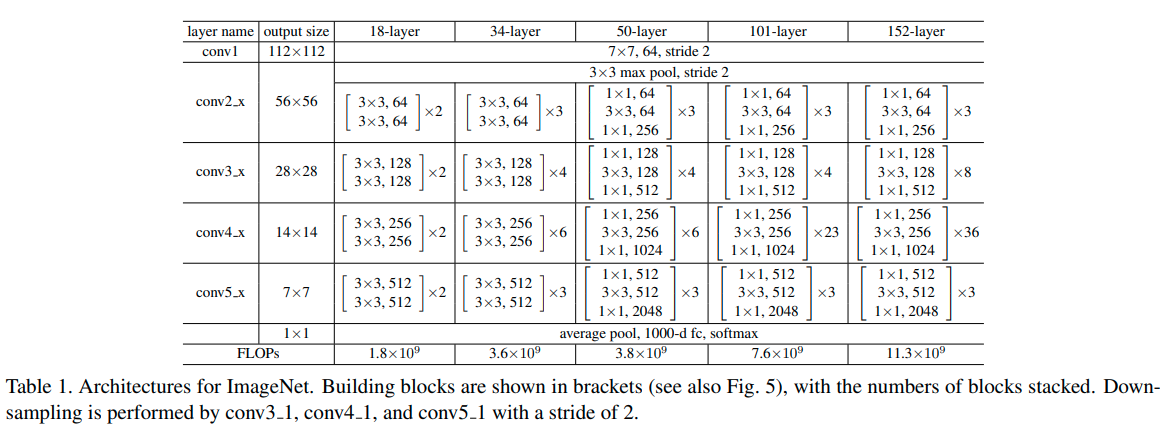

In [7]:
Image('image/resnet_table_1.png')

In [9]:
def ResNet18(input_shape, num_classes):
    return ResNet(input_shape, num_classes, 
                  block_fn=basic_block, repetitions=(2,2,2,2))

def ResNet34(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=basic_block, repetitions=(3,4,6,3))

def ResNet50(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=bottleneck_block, repetitions=(3,4,6,3))

def ResNet101(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=bottleneck_block, repetitions=(3,4,23,3))

def ResNet152(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=bottleneck_block, repetitions=(3,8,36,3))

In [10]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [11]:
model = ResNet152(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16
num_epochs = 40

In [13]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_train = len(x_train)
num_val = len(x_test)

print('# for train : %d'%(num_train))
print('# for valid : %d'%(num_val))

# for train : 50000
# for valid : 10000


In [14]:
# str_labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']
str_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [15]:
def MiniResNetBasic(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=bottleneck_block, repetitions=(3,4,6),
                 start_filters=16)

def MiniResNetBottleneck(input_shape, num_classes):
    return ResNet(input_shape, num_classes,
                 block_fn=bottleneck_block, repetitions=(3,4,6),
                 start_filters=16)

In [16]:
model = MiniResNetBasic(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_155 (Conv2D)            (None, 16, 16, 16)   2368        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_151 (Batch  (None, 16, 16, 16)  64          ['conv2d_155[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_151 (Activation)    (None, 16, 16, 16)   0           ['batch_normalization_151[0

## Training

In [17]:
model_dir = './models/resnet/basic'

In [19]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,decay=1e-6,nesterov=True)
optimizer = 'adam'
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='acc')
top5_accuracy_metric = tf.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_acc')

In [20]:
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=[accuracy_metric, top5_accuracy_metric])

In [21]:
import os

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                    restore_best_weights=True),
    
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, 
                                   histogram_freq=0, 
                                   write_graph=True,
                                   write_images=True,
                                   update_freq=100),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

In [23]:
train_dataset = (tf.keras.applications.resnet50.preprocess_input(x_train), y_train)
val_dataset = (tf.keras.applications.resnet50.preprocess_input(x_test), y_test)

In [25]:
import math

train_steps_per_epoch = math.ceil(num_train / batch_size)
val_steps_per_epoch = math.ceil(num_val / batch_size)

basic_history = model.fit(*train_dataset,
                        epochs=num_epochs,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=(val_dataset),
                        validation_steps=val_steps_per_epoch,
                        verbose=1, callbacks=callbacks)

Epoch 1/40
3125/3125 [==============================] - 57s 18ms/step - loss: 1.5456 - acc: 0.4432 - top5_acc: 0.9035 - val_loss: 1.3811 - val_acc: 0.4988 - val_top5_acc: 0.9380
Epoch 2/40
3125/3125 [==============================] - 57s 18ms/step - loss: 1.2980 - acc: 0.5356 - top5_acc: 0.9392 - val_loss: 1.2754 - val_acc: 0.5403 - val_top5_acc: 0.9430
Epoch 3/40
3125/3125 [==============================] - 56s 18ms/step - loss: 1.1285 - acc: 0.6000 - top5_acc: 0.9557 - val_loss: 1.1337 - val_acc: 0.6010 - val_top5_acc: 0.9549
Epoch 4/40
3125/3125 [==============================] - 56s 18ms/step - loss: 1.0053 - acc: 0.6441 - top5_acc: 0.9665 - val_loss: 1.0525 - val_acc: 0.6334 - val_top5_acc: 0.9637
Epoch 5/40
3125/3125 [==============================] - 56s 18ms/step - loss: 0.9069 - acc: 0.6795 - top5_acc: 0.9724 - val_loss: 0.9573 - val_acc: 0.6616 - val_top5_acc: 0.9684
Epoch 6/40
3125/3125 [==============================] - 56s 18ms/step - loss: 0.8311 - acc: 0.7073 - top5_acc:

In [38]:
model_dir = './models/resnet_bottleneck'

In [39]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                    restore_best_weights=True),
    
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, 
                                   histogram_freq=0, 
                                   write_graph=True,
                                   write_images=True,
                                   update_freq=100),
    
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}.h5')),
]

In [40]:
model = MiniResNetBottleneck(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_284 (Conv2D)            (None, 16, 16, 16)   2368        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_271 (Batch  (None, 16, 16, 16)  64          ['conv2d_284[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_271 (Activation)    (None, 16, 16, 16)   0           ['batch_normalization_271[0

In [41]:
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=[accuracy_metric, top5_accuracy_metric])

In [42]:
import math

train_steps_per_epoch = math.ceil(num_train / batch_size)
val_steps_per_epoch = math.ceil(num_val / batch_size)

bottleneck_history = model.fit(*train_dataset,
                        epochs=num_epochs,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=(val_dataset),
                        validation_steps=val_steps_per_epoch,
                        verbose=1, callbacks=callbacks)

Epoch 1/40
3125/3125 [==============================] - 57s 17ms/step - loss: 1.7646 - acc: 0.3678 - top5_acc: 0.8444 - val_loss: 1.4186 - val_acc: 0.4813 - val_top5_acc: 0.9289
Epoch 2/40
3125/3125 [==============================] - 53s 17ms/step - loss: 1.3682 - acc: 0.5106 - top5_acc: 0.9290 - val_loss: 1.2291 - val_acc: 0.5643 - val_top5_acc: 0.9519
Epoch 3/40
3125/3125 [==============================] - 53s 17ms/step - loss: 1.1676 - acc: 0.5854 - top5_acc: 0.9515 - val_loss: 1.2368 - val_acc: 0.5667 - val_top5_acc: 0.9486
Epoch 4/40
3125/3125 [==============================] - 53s 17ms/step - loss: 1.0302 - acc: 0.6358 - top5_acc: 0.9637 - val_loss: 1.0290 - val_acc: 0.6371 - val_top5_acc: 0.9659
Epoch 5/40
3125/3125 [==============================] - 53s 17ms/step - loss: 0.9241 - acc: 0.6727 - top5_acc: 0.9716 - val_loss: 1.0597 - val_acc: 0.6299 - val_top5_acc: 0.9597
Epoch 6/40
3125/3125 [==============================] - 53s 17ms/step - loss: 0.8482 - acc: 0.7015 - top5_acc:

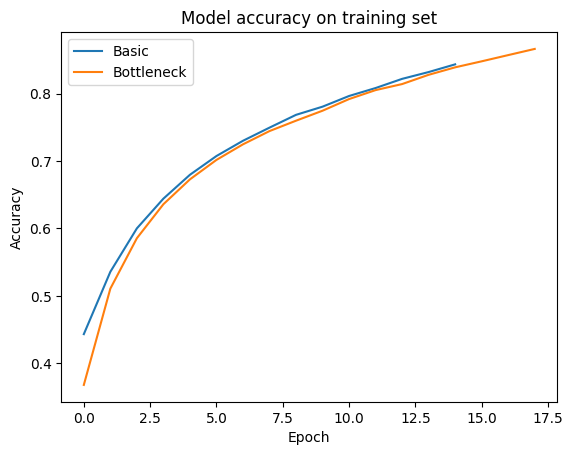

In [43]:
import matplotlib.pyplot as plt

plt.plot(basic_history.history['acc'])
plt.plot(bottleneck_history.history['acc'])
plt.title('Model accuracy on training set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Basic', 'Bottleneck'], loc='upper left')
plt.show()

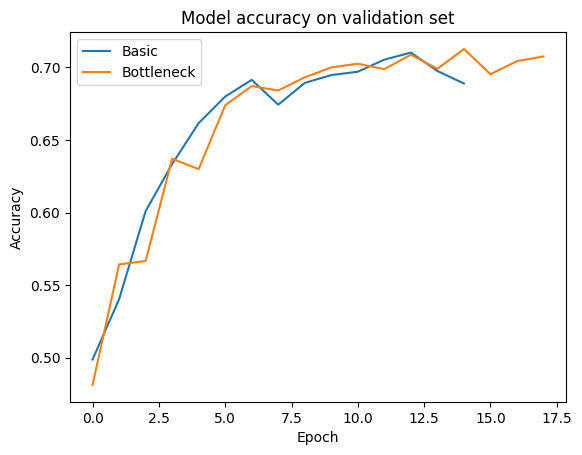

In [44]:
plt.plot(basic_history.history['val_acc'])
plt.plot(bottleneck_history.history['val_acc'])
plt.title('Model accuracy on validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Basic', 'Bottleneck'], loc='upper left')
plt.show()

In [45]:
import io
import random

import numpy as np

def image_grid():
    test_images = tf.keras.applications.resnet50.preprocess_input(x_test)
    pred = model.predict(test_images)
    pred = np.argmax(pred, axis=1)
    figure = plt.figure(figsize=(10,10))
    
    random_index = random.sample(range(len(x_test)), 25)
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=str_labels[pred[random_index[i]]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[random_index[i]], cmap=plt.cm.binary)

    return figure

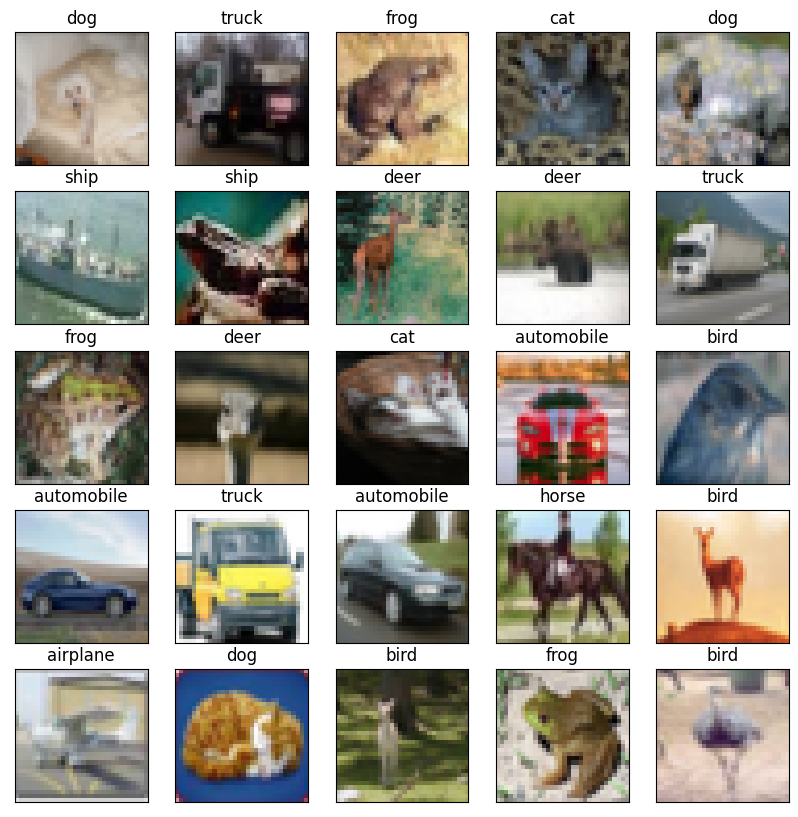

In [46]:
image_grid()